In [1]:
#导入库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision #加载图片
from torchvision import transforms #图片变换

from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
 
import numpy as np
import matplotlib.pyplot as plt #绘图
import os
import glob
from PIL import Image
import random

from preprocess import Process
from transformer import *

In [2]:
seed = 25
def get_random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
get_random_seed(seed)

In [3]:
#独热编码
def one_hot(x,class_count=10):
    return torch.eye(class_count)[x,:]

In [4]:
series = []
items = 3
step = 3
subject_num = 0
target_len = 1026

for num in range(2, 66):
    try:
        series += Process(num).prepro(target_len, step, items)
        subject_num += 1
    except:
        print(f'subject {num} abandoned')

subject 13 abandoned
subject 16 abandoned
subject 17 abandoned
subject 18 abandoned
subject 20 abandoned
subject 26 abandoned


/home/dhz/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/dhz/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


subject 42 abandoned
subject 47 abandoned
subject 48 abandoned
subject 50 abandoned


In [5]:
class MyDataset(Dataset):
    def __init__(self, series, items, subject_num):
        self.series = series
        self.codes = []
        self.subject_num = subject_num
        self.labels = np.zeros((len(self.series), self.subject_num), dtype='double')
        for i in range(self.subject_num):
            for j in range(items):
                self.labels[i * 3 + j][i] = 1.0            

    # need to overload
    def __len__(self):
        return len(self.series)

    # need to overload
    def __getitem__(self, idx):
        return torch.tensor(self.series[idx]), torch.tensor(self.labels[idx])

In [6]:
dataset = MyDataset(series, items=items, subject_num=subject_num)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

In [7]:
def second_derivative(tensor, step_size):
    # Calculate the first derivative using finite differences
    first_derivative = (tensor[2:] - 2 * tensor[1:-1] + tensor[:-2]) / (step_size ** 2)
    return first_derivative

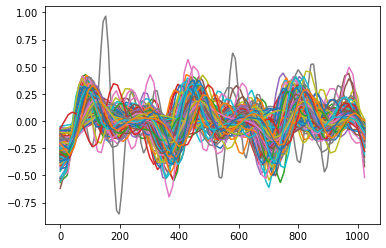

In [8]:
plt.figure()
for ser, label in dataset:
    sec_der = second_derivative(ser, 1/30.0)
    plt.plot(sec_der)
plt.show()

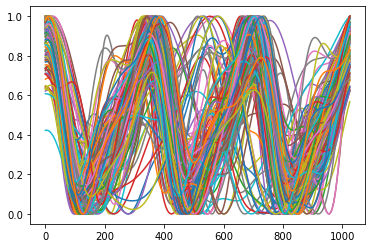

In [9]:
plt.figure()
for ser, label in dataset:
    plt.plot(ser)
plt.show()

In [10]:
interval = int(1026 / 3)
points = []
for i in range(step):
    points.append(i * interval + torch.argmin(ser[i * interval:(i + 1) * interval,]))

In [11]:
points

[tensor(125), tensor(501), tensor(831)]

In [12]:
len(series)

162

In [13]:
def normalize_tensor(input_tensor):
    """
    Normalizes the input tensor to the range [0, 1].
    
    Args:
        input_tensor (torch.Tensor): The input one-dimensional tensor.
        
    Returns:
        torch.Tensor: The normalized tensor.
    """
    min_val = torch.min(input_tensor)
    max_val = torch.max(input_tensor)
    
    normalized_tensor = (input_tensor - min_val) / (max_val - min_val)
    
    return normalized_tensor

In [14]:
def interpolate_tensor(input_tensor, target_length):
    """
    Interpolates the input tensor to the target length using linear interpolation.
    
    Args:
        input_tensor (torch.Tensor): The input one-dimensional tensor.
        target_length (int): The desired length of the output tensor.
        
    Returns:
        torch.Tensor: The interpolated tensor of the target length.
    """
    input_length = input_tensor.size(0)
    
    # Convert input tensor to NumPy array
    input_np = input_tensor.numpy()
    
    # Create interpolation indices
    input_indices = np.linspace(0, input_length - 1, input_length)
    target_indices = np.linspace(0, input_length - 1, target_length)
    
    # Interpolate using indices
    interpolated_np = np.interp(target_indices, input_indices, input_np)
    
    # Convert back to a PyTorch tensor
    interpolated_tensor = torch.tensor(interpolated_np)
    
    return interpolated_tensor

In [15]:
diff = nn.CrossEntropyLoss()
interval = int(target_len / step)
equal = []
equal_sec = []
distinct = []
distinct_sec = []
hit_rate = []
hit_rate_sec = []
TPR = []
FPR = []
TPR_sec = []
FPR_sec = []

for ser, label in dataset:
    eq_num = 0
    eq = 0
    eq_sec = 0
    dis = 0
    dis_sec = 0
    acc_num = 0
    acc_num_sec = 0
    TP = 0
    TP_sec = 0
    FP = 0
    FP_sec = 0
    TN = 0
    TN_sec = 0
    FN = 0
    FN_sec = 0
    points = []
    for i in range(step):
        points.append(i * interval + torch.argmin(ser[i * interval:(i + 1) * interval,]))
    pulses = []
    second_pulses = []
    for i in range(len(points) - 1):
        pulses.append(interpolate_tensor(ser[points[i]: points[i + 1]], 514))
        second_pulses.append(normalize_tensor(second_derivative(pulses[-1], 1/30.0)))
    threshold = diff(pulses[0], pulses[1])
    threshold_n = diff(second_pulses[0], second_pulses[1])
    for ser_n, label_n in dataset:
        if torch.equal(ser_n, ser):
            continue
        else:
            points_n = []
            for i in range(step):
                points_n.append(i * interval + torch.argmin(ser_n[i * interval:(i + 1) * interval,]))
            pulses_n = []
            second_pulses_n = []
            for i in range(len(points_n) - 1):
                pulses_n.append(interpolate_tensor(ser_n[points_n[i]: points_n[i + 1]], 514))
                second_pulses_n.append(normalize_tensor(second_derivative(pulses_n[-1], 1/30.0)))
            if torch.equal(label_n, label):
                for i in range(step - 1):
                    for j in range(step - 1):
                        eq_num += 1
                        a = diff(pulses[i], pulses_n[j])
                        eq += a
                        b = diff(second_pulses[i], second_pulses_n[j])
                        eq_sec += b
                        if a <= threshold:
                            acc_num += 1
                            TP += 1
                        else:
                            FN += 1
                        if b <= threshold_n:
                            acc_num_sec += 1
                            TP_sec += 1
                        else:
                            FN_sec += 1
            else:
                for i in range(step - 1):
                    for j in range(step - 1):
                        a = diff(pulses[i], pulses_n[j])
                        dis += a
                        b = diff(second_pulses[i], second_pulses_n[j])
                        dis_sec += b
                        if a > threshold:
                            acc_num += 1
                            TN += 1
                        else:
                            FP += 1
                        if b > threshold_n:
                            acc_num_sec += 1
                            TN_sec += 1
                        else:
                            FP_sec += 1
    equal.append((eq / (eq_num)).item())
    equal_sec.append((eq_sec / (eq_num)).item())
    distinct.append((dis / ((len(series) - 1) * (step - 1) * (step - 1) - eq_num)).item())
    distinct_sec.append((dis_sec / ((len(series) - 1) * (step - 1) * (step - 1) - eq_num)).item())
    hit_rate.append(acc_num / ((len(series) - 1) * (step - 1) * (step - 1) - eq_num))
    hit_rate_sec.append(acc_num_sec / ((len(series) - 1) * (step - 1) * (step - 1) - eq_num))
    TPR.append(TP / (TP + FN))
    TPR_sec.append(TP_sec / (TP_sec + FN_sec))
    FPR.append(FP / (FP + TN))
    FPR_sec.append(FP_sec / (FP_sec + TN_sec))

In [16]:
pro = 0
for i in range(len(hit_rate)):
    if hit_rate_sec[i] > hit_rate[i]:
        pro += 1
print(pro / len(hit_rate))

0.5061728395061729


In [17]:
t_pro = 0
for i in range(len(TPR)):
    if TPR_sec[i] >= TPR[i]:
        t_pro += 1
print(t_pro / len(TPR))

0.6111111111111112


In [18]:
f_pro = 0
for i in range(len(FPR)):
    if FPR_sec[i] <= FPR[i]:
        f_pro += 1
print(f_pro / len(FPR))

0.5185185185185185


In [19]:
pro = 0
for i in range(len(equal)):
    if equal_sec[i] < equal[i]:
        pro += 1
print(pro / len(equal))

0.2839506172839506


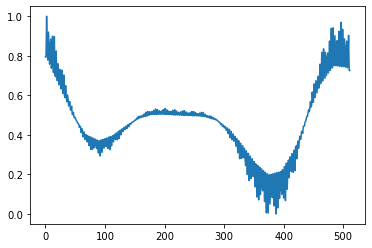

In [20]:
plt.plot(second_pulses_n[-1])